# QuakeMigrate example - Icequake detection at the Rutford icestream

## Overview

This notebook contains another example showing how to run QuakeMigrate for icequake detection.

Here, we detail how to:
1. Create travel-time lookup tables for the example seismometer network
2. Run the detect stage to coalesce energy through time
3. Run the trigger stage to determine events above a threshold value
4. Run the locate stage to refine the earthquake location

In [5]:
from pyproj import Proj

import pandas as pd

from QMigrate.io import Archive
from QMigrate.io import stations as read_stations
from QMigrate.lut import compute, LUT
from QMigrate.signal import QuakeScan, Trigger
from QMigrate.signal.onset import STALTAOnset
from QMigrate.signal.pick import GaussianPicker

%matplotlib inline

In [6]:
# --- i/o paths ---
station_file = "./inputs/rutford_stations.txt"
data_in = "./inputs/mSEED"
lut_out = "./outputs/lut/icequake.LUT"
run_path = "./outputs/runs"
run_name = "icequake_example"

## 1. Create travel-time lookup tables (LUTs)

In [9]:
# --- Read in the station information file ---
stations = read_stations(station_file)

# --- Define projections ---
cproj = Proj(proj="longlat", ellps="WGS84", datum="WGS84", no_defs=True)
gproj = Proj(proj="lcc", lon_0=-83.932, lat_0=-78.144, lat_1=-78.1, lat_2=-77.9,
             datum="WGS84", ellps="WGS84", units="m", no_defs=True)

# --- Create new LUT ---
# Cell count (x,y,z); cell size (x,y,z in metres)
lut = LUT(ll_corner=[-84.14853353566141, -78.18825429331356, -350.],
          ur_corner=[-83.71921885073093, -78.10003166259442, 3550],
          cell_size=[100., 100., 100.], grid_proj=gproj, coord_proj=cproj)

# --- Homogeneous LUT generation ---
vp = 3841
vs = 1970
compute(lut, stations, method="homogeneous", vp=vp, vs=vs)

# --- Save LUT ---
lut.save(lut_out)

Computing homogeneous traveltime lookup table - 1 of 10
Computing homogeneous traveltime lookup table - 2 of 10
Computing homogeneous traveltime lookup table - 3 of 10
Computing homogeneous traveltime lookup table - 4 of 10
Computing homogeneous traveltime lookup table - 5 of 10
Computing homogeneous traveltime lookup table - 6 of 10
Computing homogeneous traveltime lookup table - 7 of 10
Computing homogeneous traveltime lookup table - 8 of 10
Computing homogeneous traveltime lookup table - 9 of 10
Computing homogeneous traveltime lookup table - 10 of 10


## 2. Coalesce the seismic energy through time

In [12]:
# --- Read in station file ---
stations = read_stations(station_file)

# --- Create new Archive and set path structure ---
archive = Archive(archive_path=data_in, stations=stations,
                  archive_format="YEAR/JD/*_STATION_*")

# --- Create new Onset ---
onset = STALTAOnset(position="classic")
onset.p_bp_filter = [20, 200, 4]
onset.s_bp_filter = [10, 125, 4]
onset.p_onset_win = [0.01, 0.25]
onset.s_onset_win = [0.05, 0.5]

# --- Create new QuakeScan ---
scan = QuakeScan(archive, lut, onset=onset, run_path=run_path,
                 run_name=run_name)

# --- Set detect parameters ---
scan.sampling_rate = 1000
scan.timestep = 0.75
scan.threads = 12

# --- Set time period over which to run detect ---
starttime = "2009-01-21T04:00:05.0"
endtime = "2009-01-21T04:00:15.0"

In [14]:
# --- Run detect ---
scan.detect(starttime, endtime)

	QuakeMigrate RUN - Path: outputs/runs/icequake_example - Name: icequake_example

	DETECT - Continuous coalescence scan

	Scanning from 2009-01-21T04:00:05.000000Z to 2009-01-21T04:00:15.000000Z

	Scan parameters:
		Data sampling rate = 1000 Hz
		Time step = 0.75 s
		Marginal window = 2.0 s
		Thread count = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 1000 Hz

		Bandpass filter P  = [20, 200, 4] (Hz, Hz, -)
		Bandpass filter S  = [10, 125, 4] (Hz, Hz, -)

		Onset P [STA, LTA] = [0.01, 0.25] (s, s)
		Onset S [STA, LTA] = [0.05, 0.5] (s, s)

~~~~~~~~~~~~~~~~~~~~ Processing : 2009-01-21T04:00:03.350000Z-2009-01-21T04:00:13.750000Z ~~~~~~~~~~~~~~~~~~~~
                     Elapsed time: 2.592068 seconds.
~~~~~~~~~~~~~~~~~~~~ Processing : 2009-01-21T04:00:04.100000Z-2009-01-21T04:00:14.500000Z ~~~~~~~~~~~~~~~~~~~~
                     Elapsed time: 2.511934 seconds.
~~~~~~~~~~~~~~~~~~~~ Processing : 2009-01-21T04:00:04.850000Z-2009-01-21T04:00:15.250000Z ~~

## 3. Run the trigger stage, to detect and output individual icequakes

nb: We can use the same QuakeScan object here because we are not using a different decimation. If running trigger and locate on grids with different levels of decimation, a new QuakeScan object should be created.

	QuakeMigrate RUN - Path: outputs/runs/icequake_example - Name: icequake_example

	TRIGGER - Triggering events from coalescence

	Triggering events from 2009-01-21T04:00:05.000000Z to 2009-01-21T04:00:15.000000Z

	Trigger parameters:
		Pre/post pad = 120.0 s
		Marginal window = 0.1 s
		Minimum repeat  = 0.5 s

		Triggering from normalised coalescence stream.

		Detection threshold method: static
		Static threshold = 2.75

	Reading in .scanmseed...
	    Warning!
	    No .scanmseed data found for pre-pad!
	    Warning!
	    No .scanmseed data found for post-pad!
	...from 2009-01-21T04:00:05.000000Z - 2009-01-21T04:00:15.499000Z.
	.scanmseed read complete.

	Triggering events...
	    Triggered event 1 of 1
	Writing triggered events to file...

	Plotting trigger summary...
	Reading in .StationAvailability...
	...from 2009-01-21T04:00:05.000000Z - 2009-01-21T04:00:14.750000Z
	.StationAvailability read complete.


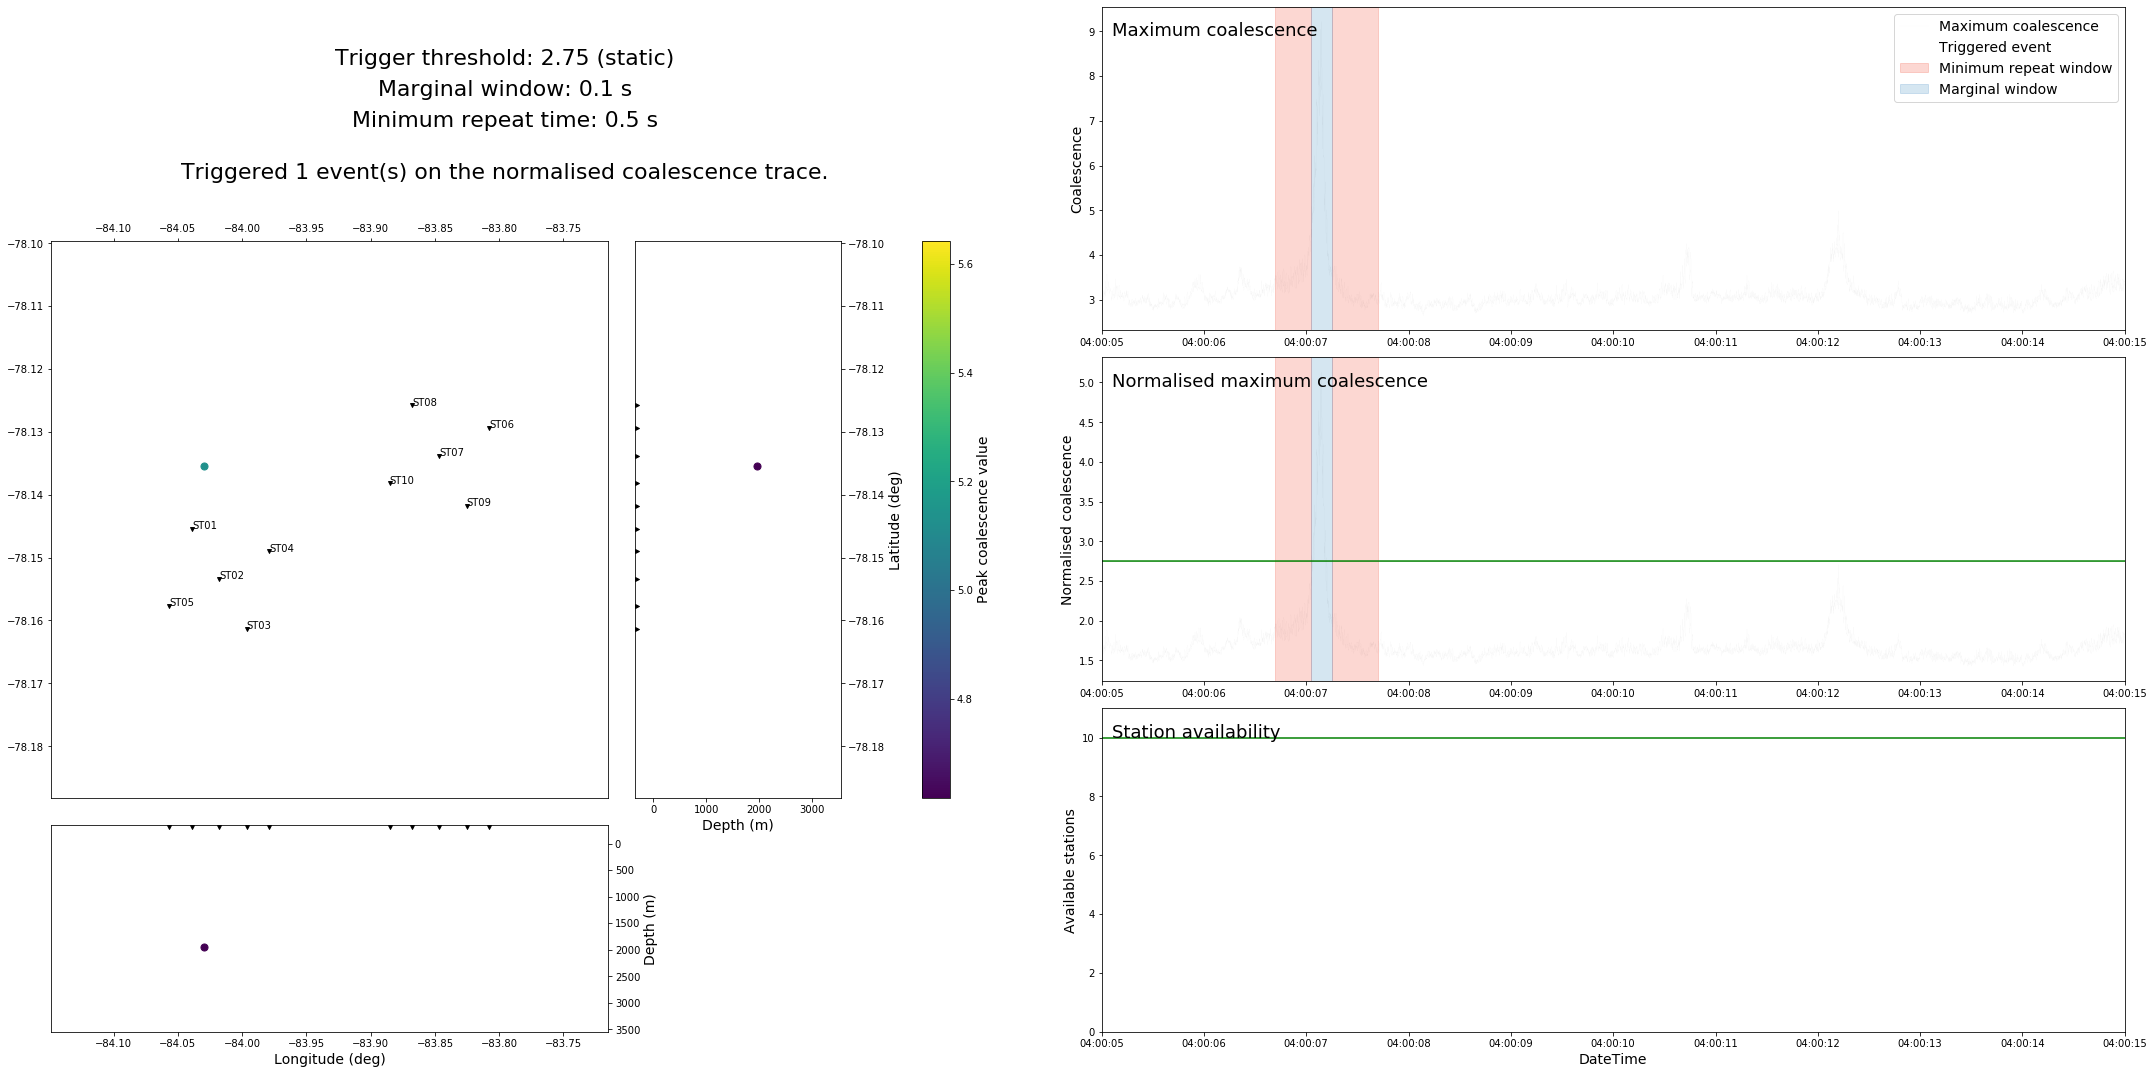

In [15]:
# --- Create new Trigger ---
trig = Trigger(lut, run_path, run_name)

# --- Set trigger parameters ---
trig.marginal_window = 0.1
trig.minimum_repeat = 0.5
trig.normalise_coalescence = True

# --- Static threshold ---
trig.threshold_method = "static"
trig.static_threshold = 2.75

# --- Run trigger ---
trig.trigger(starttime, endtime, savefig=True)

## 4. Run the locate stage, to relocate triggered events on a less decimated grid

In [16]:
# --- Create new PhasePicker ---
picker = GaussianPicker(onset=onset)
picker.marginal_window = 0.1
picker.plot_picks = True

# --- Create new QuakeScan ---
scan = QuakeScan(archive, lut, onset=onset, picker=picker,
                 run_path=run_path, run_name=run_name, log=True)

# --- Set locate parameters ---
scan.marginal_window = 0.1
scan.threads = 12
scan.sampling_rate = 1000

# Turn on plotting features
scan.plot_event_summary = True
scan.plot_event_video = False

# --- Toggle writing of waveforms ---
scan.write_cut_waveforms = False

In [18]:
# --- Run locate ---
scan.locate(starttime=starttime, endtime=endtime)

	QuakeMigrate RUN - Path: outputs/runs/icequake_example - Name: icequake_example

	LOCATE - Determining event location and uncertainty

	Locating events from 2009-01-21T04:00:05.000000Z to 2009-01-21T04:00:15.000000Z

	Scan parameters:
		Data sampling rate = 1000 Hz
		Time step = 120.0 s
		Marginal window = 0.1 s
		Thread count = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 1000 Hz

		Bandpass filter P  = [20, 200, 4] (Hz, Hz, -)
		Bandpass filter S  = [10, 125, 4] (Hz, Hz, -)

		Onset P [STA, LTA] = [0.01, 0.25] (s, s)
		Onset S [STA, LTA] = [0.05, 0.5] (s, s)

	Phase picking by fitting a 1-D Gaussian to onsets
		Pick threshold  = 1.0
		Marginal window = 0.1 s
		Search window   = 10.0% of travel-time


	EVENT - 1 of 1 - 20090121040007151
	Determining event location...
	Reading waveform data...
                     Elapsed time: 0.142211 seconds.
	Computing 4-D coalescence function...
                     Elapsed time: 1.423914 seconds.
	Determining ev

## 5. Some of the key outputs

In [23]:
# Show the .event file, containing event origin time and location:
icequake_event_fname = "./outputs/runs/icequake_example/locate/events/20090121040007151.event"
event_df = pd.read_csv(icequake_event_fname)

event_df

,DT,COA,COA_NORM,X,Y,Z,LocalGaussian_X,LocalGaussian_Y,LocalGaussian_Z,LocalGaussian_ErrX,...,GlobalCovariance_Y,GlobalCovariance_Z,GlobalCovariance_ErrX,GlobalCovariance_ErrY,GlobalCovariance_ErrZ,TRIG_COA,DEC_COA,DEC_COA_NORM,ML,ML_Err
0,2009-01-21T04:00:07.151000Z,9.220398,5.129951,-84.030429,-78.135564,1960.0,-84.027718,-78.136172,1911.992348,8.96848,...,-78.135703,1949.272805,143.096294,226.761305,191.772805,5.12995,9.2204,5.12995,NaN,NaN


In [24]:
# Show the .picks file, containing station time picks:
icequake_pick_fname = "outputs/runs/icequake_example/locate/picks/20090121040007151.picks"
pick_df = pd.read_csv(icequake_pick_fname)

pick_df

,Station,Phase,ModelledTime,PickTime,PickError,SNR
0,ST01,P,2009-01-21T04:00:07.807875Z,2009-01-21T04:00:07.804628Z,0.017118,24.004905
1,ST01,S,2009-01-21T04:00:08.431740Z,-1,-1.000000,-1.000000
2,ST02,P,2009-01-21T04:00:07.939722Z,2009-01-21T04:00:07.937651Z,0.008168,25.095561
3,ST02,S,2009-01-21T04:00:08.688807Z,2009-01-21T04:00:08.695058Z,0.062021,10.333160
4,ST03,P,2009-01-21T04:00:08.125067Z,2009-01-21T04:00:08.118926Z,0.008977,24.981087
5,ST03,S,2009-01-21T04:00:09.050183Z,-1,-1.000000,-1.000000
6,ST04,P,2009-01-21T04:00:07.921087Z,2009-01-21T04:00:07.917593Z,0.030367,23.617772
7,ST04,S,2009-01-21T04:00:08.652475Z,2009-01-21T04:00:08.660640Z,0.058617,10.488054
8,ST05,P,2009-01-21T04:00:08.038745Z,2009-01-21T04:00:08.033220Z,0.012694,24.094823
9,ST05,S,2009-01-21T04:00:08.881878Z,-1,-1.000000,-1.000000


In [22]:
# Show the coalescence pdf file, containing event origin time and location:
icequake_coal_image_fname = "outputs/runs/icequake_example/locate/summaries/icequake_example_20090121040007151_EventSummary.pdf"
from IPython.display import IFrame # For plotting pdf
IFrame(icequake_coal_image_fname, width=800, height=400) # Plot pdf